# MOVIE PREDICTION

###  Part 1 : Data and Library Imports

##### Importing Packages

In [79]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from sklearn.cluster import KMeans

##### Loading in Data

In [2]:
prime_df = pd.read_csv('prime_titles.csv')
hulu_df=pd.read_csv('hulu_titles.csv')
netflix_df=pd.read_csv('netflix_titles.csv')
prime_creds=pd.read_csv('credits_prime.csv')
hulu_creds=pd.read_csv('credits_hulu.csv')
netflix_creds=pd.read_csv('credits_netflix.csv')

##### Creating a new column to indicate which streaming platform the data is from 

In [3]:
prime_df = (prime_df.assign(service="amazon"))
hulu_df = (hulu_df.assign(service="hulu"))
netflix_df=(netflix_df.assign(service="netflix"))

In [4]:
prime_df=(pd.merge(prime_df, prime_creds, on='id'))
hulu_df=(pd.merge(hulu_df, hulu_creds, on='id'))
netflix_df=(pd.merge(netflix_df, hulu_creds, on='id'))

##### Combining both dataframes into one massive one

In [5]:
df=pd.concat([prime_df,hulu_df,netflix_df],axis=0,join='inner')

### Part 2 : Data Exploration

In [6]:
print(df.head())

        id              title   type  \
0  ts20945  The Three Stooges   SHOW   
1  ts20945  The Three Stooges   SHOW   
2  ts20945  The Three Stooges   SHOW   
3  tm19248        The General  MOVIE   
4  tm19248        The General  MOVIE   

                                         description  release_year  \
0  The Three Stooges were an American vaudeville ...          1934   
1  The Three Stooges were an American vaudeville ...          1934   
2  The Three Stooges were an American vaudeville ...          1934   
3  During America’s Civil War, Union spies steal ...          1926   
4  During America’s Civil War, Union spies steal ...          1926   

  age_certification  runtime  \
0             TV-PG       19   
1             TV-PG       19   
2             TV-PG       19   
3               NaN       78   
4               NaN       78   

                                              genres production_countries  \
0  ['comedy', 'family', 'animation', 'action', 'f...               [

In [7]:
print(df.columns)

Index(['id', 'title', 'type', 'description', 'release_year',
       'age_certification', 'runtime', 'genres', 'production_countries',
       'seasons', 'imdb_id', 'imdb_score', 'imdb_votes', 'tmdb_popularity',
       'tmdb_score', 'service', 'person_id', 'name', 'character', 'role'],
      dtype='object')


In [8]:
df['actor'] = df.apply(lambda row: row['name'] if row['role'] == 'ACTOR' else None, axis=1)
df['director'] = df.apply(lambda row: row['name'] if row['role'] != 'ACTOR' else None, axis=1)

In [9]:
df = df.groupby('id', as_index=False).agg({
    'title': 'first',
    'type': 'first',
    'description': 'first',
    'release_year': 'first',
    'age_certification': 'first',
    'runtime': 'first',
    'genres': 'first',
    'production_countries': 'first',
    'seasons': 'first',
    'imdb_id': 'first',
    'imdb_score': 'first',
    'imdb_votes': 'first',
    'tmdb_popularity': 'first',
    'tmdb_score': 'first',
    'service': 'first',
    'actor': lambda x: list(x),
    'person_id': lambda x: list(x),
    'name': lambda x: list(x),
    'character': lambda x: list(x),
    'role': lambda x: list(x),
    'director': lambda x: list(x)
})


In [10]:
def extract_director(directors_list):
    for director in directors_list:
        if director is not None:
            if isinstance(director, dict):
                return director['name']
            else:
                return director
    return None

df['director'] = df['director'].apply(extract_director)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10947 entries, 0 to 10946
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10947 non-null  object 
 1   title                 10947 non-null  object 
 2   type                  10947 non-null  object 
 3   description           10925 non-null  object 
 4   release_year          10947 non-null  int64  
 5   age_certification     4762 non-null   object 
 6   runtime               10947 non-null  int64  
 7   genres                10947 non-null  object 
 8   production_countries  10947 non-null  object 
 9   seasons               2114 non-null   float64
 10  imdb_id               10234 non-null  object 
 11  imdb_score            10113 non-null  float64
 12  imdb_votes            10108 non-null  float64
 13  tmdb_popularity       10939 non-null  float64
 14  tmdb_score            9626 non-null   float64
 15  service            

##### Dealing with missing values

In [12]:
df.isna()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,...,imdb_votes,tmdb_popularity,tmdb_score,service,actor,person_id,name,character,role,director
0,False,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10942,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
10943,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
10944,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
10945,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [13]:
df.isna().sum()

id                         0
title                      0
type                       0
description               22
release_year               0
age_certification       6185
runtime                    0
genres                     0
production_countries       0
seasons                 8833
imdb_id                  713
imdb_score               834
imdb_votes               839
tmdb_popularity            8
tmdb_score              1321
service                    0
actor                      0
person_id                  0
name                       0
character                  0
role                       0
director                2094
dtype: int64

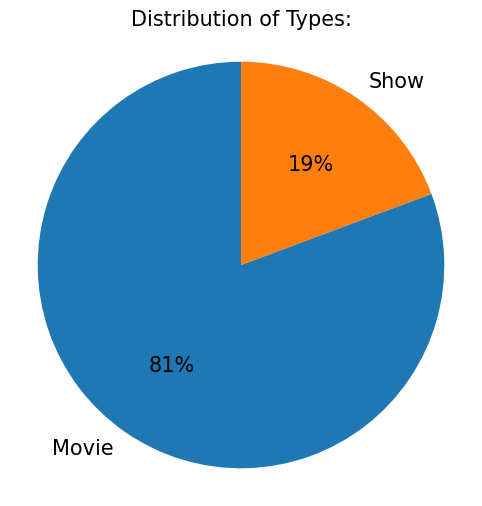

In [14]:
plt.figure(figsize=(10,6))
plt.title('Distribution of Types:', fontsize=15)
plt.pie(df.type.value_counts(), 
        labels=['Movie', 'Show'],
        textprops={"fontsize":15},
        radius=1.1, startangle=90,
        autopct='%.0f%%')
plt.show()

In [15]:
movie_count = df[df['type'] == 'MOVIE'].shape[0]
show_count = df[df['type'] == 'SHOW'].shape[0]
print(f"Number of movies: {movie_count}")
print(f"Number of TV shows: {show_count}")

Number of movies: 8833
Number of TV shows: 2114


##### Summary variable

In [16]:
descriptions = (pd.DataFrame(df.description.dropna())).reset_index()
mas = []
for i in range(5832):
  w = descriptions.description[i]
  ww = w.split()
  mas.append(ww)

data = []
for i in mas:
    for j in range(len(i)):
        data.append(i[j].lower())
        
big_string=''
for i in range(len(data)):
    big_string+=(data[i]+' ')

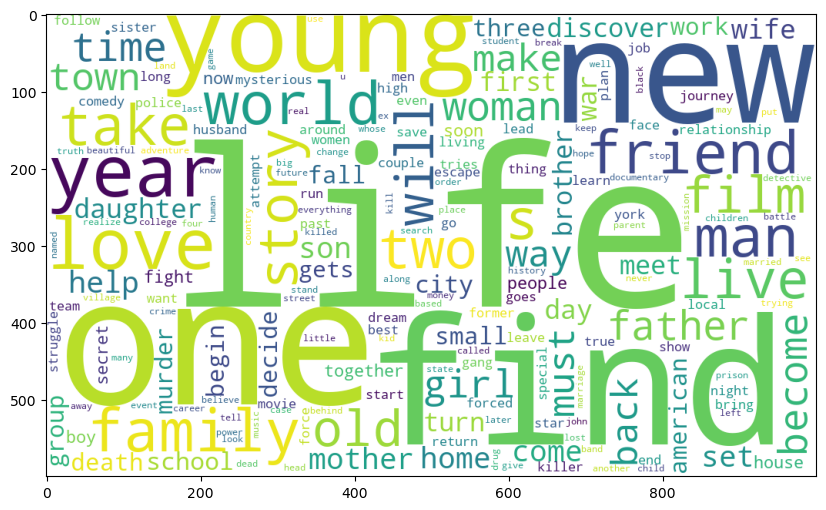

In [17]:
wordCloud = WordCloud(width = 1000, height = 600, random_state=1,background_color='white', collocations=False).generate(big_string)

plt.figure(figsize=(10,6))
plt.imshow(wordCloud)

#### Part 3 : Data Cleaning

##### Genre and production country columns are lists- need to get a top category

#####  1. genre 

In [18]:
df['genres'] = df['genres'].str.strip("[]'")

In [19]:
genres_df = df['genres'].str.split(', ', expand=True)

In [20]:
genres_df.columns = [f'genre_{i}' for i in range(genres_df.shape[1])]

In [21]:
df = pd.concat([df, genres_df], axis=1)

In [22]:
df['genre_0'] = df['genre_0'].str.strip("'")
df['genre_1'] = df['genre_1'].str.strip("'")
df['genre_2'] = df['genre_2'].str.strip("'")
df['genre_3'] = df['genre_3'].str.strip("'")
df['genre_4'] = df['genre_4'].str.strip("'")
df['genre_5'] = df['genre_5'].str.strip("'")
df['genre_6'] = df['genre_6'].str.strip("'")
df['genre_7'] = df['genre_7'].str.strip("'")
df['genre_8'] = df['genre_8'].str.strip("'")

In [23]:
df.drop(['genres'], axis=1, inplace=True)

In [24]:
df.head()

,id,title,type,description,release_year,age_certification,runtime,production_countries,seasons,imdb_id,...,director,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8
0,tm100001,The Lucky Texan,MOVIE,"Jerry Mason, a young Texan, and Jake Benson, a...",1934,None,61,['US'],NaN,tt0025440,...,Robert N. Bradbury,western,action,romance,None,None,None,None,None,None
1,tm1000022,Boonie Bears: The Wild Life,MOVIE,Bear brothers Briar and Bramble set off on an ...,2021,None,99,['CN'],NaN,tt11654032,...,Leon Ding,scifi,animation,None,None,None,None,None,None,None
2,tm1000070,Bad Luck Banging or Loony Porn,MOVIE,"Emi, a school teacher, finds her career and re...",2021,None,106,"['HR', 'LU', 'GB', 'RO', 'CH', 'CZ']",NaN,tt14033502,...,Radu Jude,drama,comedy,None,None,None,None,None,None,None
3,tm1000169,Bad Cupid,MOVIE,Archie is a God on a mission to ensure that tr...,2021,None,81,[],NaN,tt11333938,...,Diane Cossa,romance,comedy,None,None,None,None,None,None,None
4,tm1000203,Digging to Death,MOVIE,David Van Owen moves into a mysterious house a...,2021,None,96,['US'],NaN,tt7752100,...,Michael P. Blevins,horror,thriller,None,None,None,None,None,None,None


In [25]:
df['genre_0'].unique()

array(['western', 'scifi', 'drama', 'romance', 'horror', 'thriller',
       'comedy', 'crime', 'family', 'documentation', 'action', 'fantasy',
       'music', '', 'animation', 'history', 'war', 'european', 'sport',
       'reality'], dtype=object)

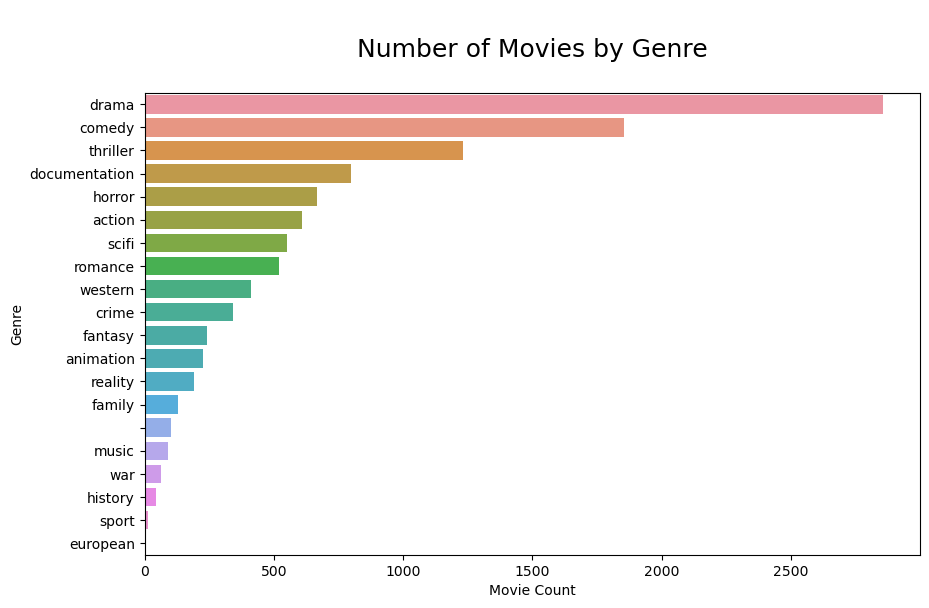

In [26]:
bp_df = pd.DataFrame(df.genre_0.value_counts())
order = bp_df.index
plt.figure(figsize=(10,6))
plt.title('\nNumber of Movies by Genre\n', fontsize=18)
sns.countplot(y=df.genre_0, order=order)
plt.xlabel('Movie Count')
plt.ylabel('Genre')
plt.show()

#####  2. Seasons  

In [27]:
df.loc[df['type'] == 'MOVIE', ['seasons']] = 0

#####  3. Production Countries 

In [28]:
df['production_countries'] = df['production_countries'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')
df['lead_prod_country'] = df['production_countries'].str.split(',').str[0]

# Let's also add a number of countries, envolved in movie making, so that we save a little more data
df['prod_countries_cnt'] = df['production_countries'].str.split(',').str.len()
df.lead_prod_country = df.lead_prod_country.replace('', np.nan)

/var/folders/sk/lkcllkb10nl1_6_s1z575s300000gp/T/ipykernel_13528/2226315985.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['production_countries'] = df['production_countries'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')


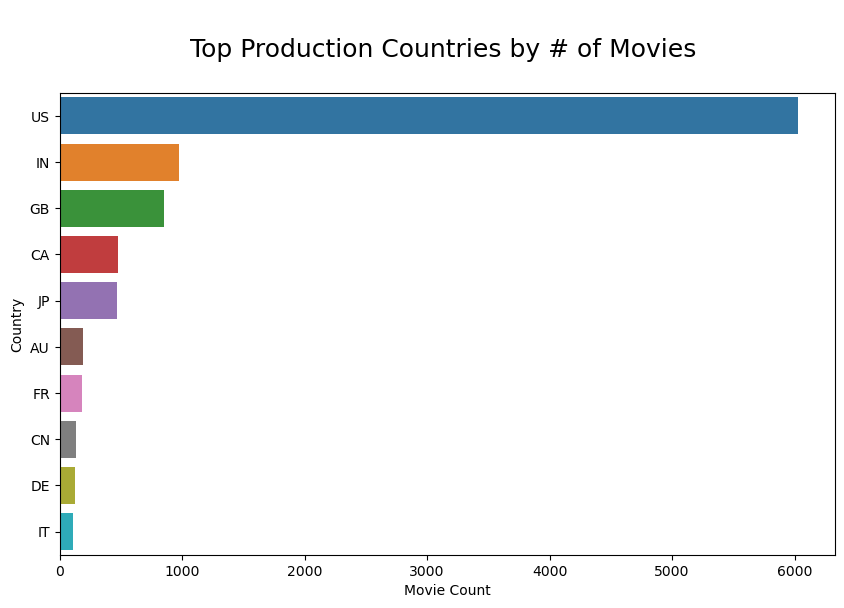

In [29]:
bp_df = pd.DataFrame(df.lead_prod_country.value_counts()).head(10)
order = bp_df.index
plt.figure(figsize=(10,6))
plt.title('\nTop Production Countries by # of Movies \n', fontsize=18)
sns.countplot(y=df.lead_prod_country, order=order)
plt.xlabel('Movie Count')
plt.ylabel('Country')
plt.show()

In [30]:
#df.dropna(inplace=True)

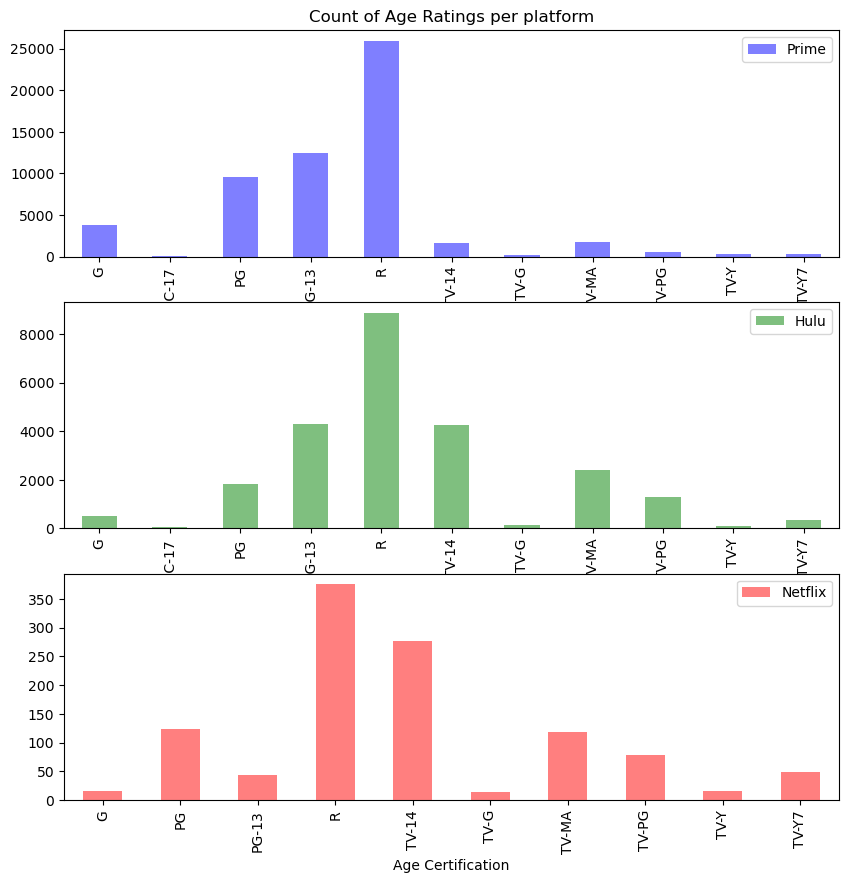

In [31]:
fig, ax = plt.subplots(3,figsize=(10, 10))

# Plot the first line
prime_df.groupby(['age_certification']).size().plot.bar(ax=ax[0], color='blue', alpha=0.5, label='Prime')

# Plot the second line
hulu_df.groupby(['age_certification']).size().plot.bar(ax=ax[1], color='green', alpha=0.5, label='Hulu')
# Plot the third line
netflix_df.groupby(['age_certification']).size().plot.bar(ax=ax[2], color='red', alpha=0.5, label='Netflix')

# Set the title and labels
ax[0].set_title('Count of Age Ratings per platform')
ax[2].set_xlabel('Age Certification')



# Set the legend
ax[0].legend()
ax[1].legend()
ax[2].legend()

# Show the plot
plt.show()

#### Cleaning Actor Column

In [32]:
# converting the list to a string

In [33]:
df['actor'] = df['actor'].apply(lambda x: ' '.join([a if a is not None else '' for a in x]))

#####  3. Weighted ratings

In [34]:
v=df['imdb_votes']
R=df['imdb_score']
c=df['imdb_score'].mean()
m=df['imdb_votes'].quantile(0.9)

In [35]:
df['weighted_avg']=((R*v)+ (c*m))/(v+m)

Text(0, 0.5, 'Movie Name')

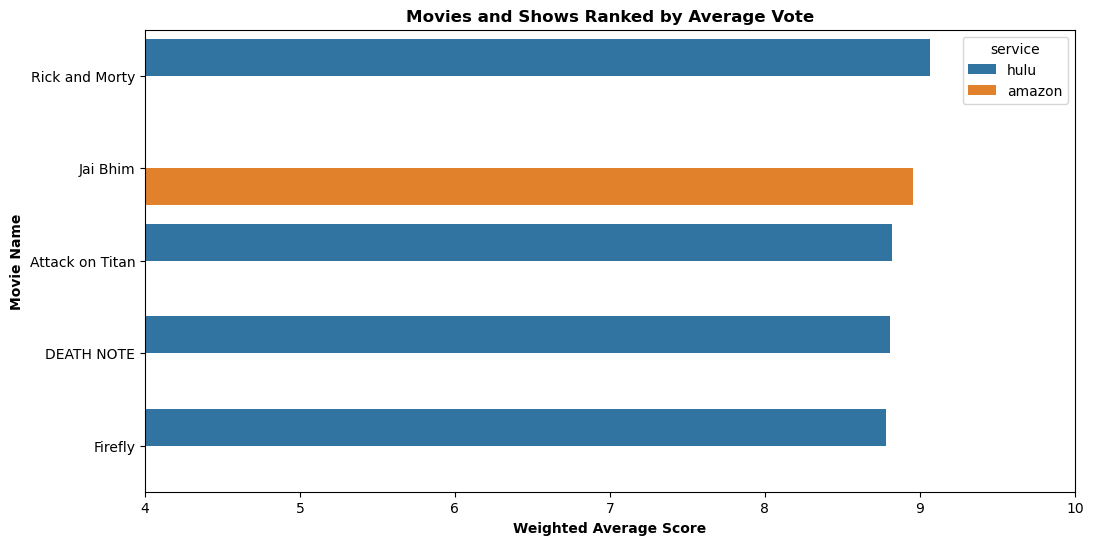

In [36]:
weight_average= df.sort_values('weighted_avg',ascending=False)


plt.figure(figsize=(12, 6))
axis1=sns.barplot(x=weight_average['weighted_avg'].head(5),y=weight_average['title'].head(5),
                   hue=weight_average['service'].head(5),data=weight_average)
plt.xlim(4,10)

plt.title('Movies and Shows Ranked by Average Vote',weight='bold')
plt.xlabel('Weighted Average Score',weight='bold')
plt.ylabel('Movie Name',weight='bold')


In [37]:
print(df['service'].nunique())

2


In [38]:
df.corr()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,prod_countries_cnt,weighted_avg
release_year,1.000000,0.037572,0.041192,0.056977,0.034921,0.071560,0.161601,0.062957,0.039326
runtime,0.037572,1.000000,-0.379047,-0.190593,0.086361,-0.087868,-0.203385,0.114632,-0.093569
seasons,0.041192,-0.379047,1.000000,0.228302,0.081411,0.191224,0.215784,-0.049240,0.252689
imdb_score,0.056977,-0.190593,0.228302,1.000000,0.210323,0.106992,0.619006,0.035537,0.549098
imdb_votes,0.034921,0.086361,0.081411,0.210323,1.000000,0.202809,0.166493,0.067542,0.574544
tmdb_popularity,0.071560,-0.087868,0.191224,0.106992,0.202809,1.000000,0.129951,0.014033,0.207499
tmdb_score,0.161601,-0.203385,0.215784,0.619006,0.166493,0.129951,1.000000,0.020882,0.401852
prod_countries_cnt,0.062957,0.114632,-0.049240,0.035537,0.067542,0.014033,0.020882,1.000000,0.037293
weighted_avg,0.039326,-0.093569,0.252689,0.549098,0.574544,0.207499,0.401852,0.037293,1.000000


#####  4. Release Year

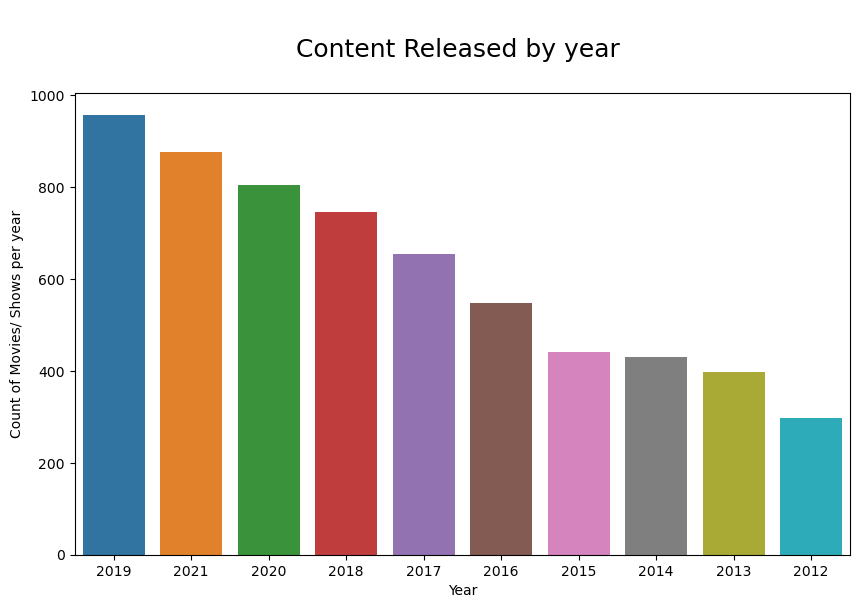

In [39]:
bp_df = pd.DataFrame(df.release_year.value_counts()).head(10)
order = bp_df.index
plt.figure(figsize=(10,6))
plt.title('\nContent Released by year \n', fontsize=18)
sns.countplot(x=df.release_year, order=order)
plt.xlabel('Year')
plt.ylabel('Count of Movies/ Shows per year')
plt.show()

In [40]:
df.columns

Index(['id', 'title', 'type', 'description', 'release_year',
       'age_certification', 'runtime', 'production_countries', 'seasons',
       'imdb_id', 'imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score',
       'service', 'actor', 'person_id', 'name', 'character', 'role',
       'director', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4',
       'genre_5', 'genre_6', 'genre_7', 'genre_8', 'lead_prod_country',
       'prod_countries_cnt', 'weighted_avg'],
      dtype='object')

###### Checking for and getting rid of NA vals

In [41]:
df.drop(df.loc[((df['tmdb_score'].isna()) & (df['tmdb_popularity'].isna()))].index, 
                axis = 0, inplace = True)

In [42]:
((df.isnull().sum()/df.shape[0])*100).sort_values(ascending = False)

genre_8                 99.936009
genre_7                 99.725752
genre_6                 99.140689
genre_5                 97.422068
genre_4                 92.695859
genre_3                 80.903190
genre_2                 57.537252
age_certification       56.467684
genre_1                 28.037298
director                19.124234
tmdb_score              12.002925
weighted_avg             7.651522
imdb_votes               7.651522
imdb_score               7.605814
imdb_id                  6.517963
lead_prod_country        3.693208
description              0.182832
prod_countries_cnt       0.000000
genre_0                  0.000000
id                       0.000000
role                     0.000000
character                0.000000
name                     0.000000
title                    0.000000
actor                    0.000000
service                  0.000000
tmdb_popularity          0.000000
seasons                  0.000000
production_countries     0.000000
runtime       

In [43]:
df[(df.type == 'SHOW') & (df.imdb_score >= 9) & (df.tmdb_score>=9)][['actor', 'imdb_score', 'tmdb_score', 'title']].reset_index().drop('index', axis = 1)

,actor,imdb_score,tmdb_score,title
0,Lilía Herrera Mosk Marrero Carlos Kapistrán Mi...,9.0,10.0,Corazón Contento
1,William Toti,9.3,9.1,9/11: One Day in America
2,Jonathan Roumie Elizabeth Tabish Jordan Walker...,9.4,9.4,The Chosen


In [44]:
df.drop(['id', 'imdb_id','person_id','genre_3','genre_4','genre_5','genre_6','genre_7','genre_8'], axis=1, inplace=True)

### Part 3. Model Building 

## Similarity Score

In [45]:
df['index_column'] = df.index

In [46]:
features = ['type', 'production_countries', 'genre_0', 'director','actor','description']
for feature in features:
    df[feature] = df[feature].fillna('')

In [47]:
def combined_features(row):
    return row['type']+" "+row['production_countries']+" "+row['genre_0']+" "+row['director']+" "+row['actor']+" "+row['description']
                                                                                                                    
df["combined_features"] = df.apply(combined_features, axis =1)

In [48]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df["combined_features"])
print("Count Matrix:", count_matrix.toarray())

Count Matrix: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [49]:
cosine_sim = cosine_similarity(count_matrix)

In [50]:
df['description'].head()

0    Jerry Mason, a young Texan, and Jake Benson, a...
1    Bear brothers Briar and Bramble set off on an ...
2    Emi, a school teacher, finds her career and re...
3    Archie is a God on a mission to ensure that tr...
4    David Van Owen moves into a mysterious house a...
Name: description, dtype: object

In [51]:
data= df[features]

In [59]:
df.head()

,title,type,description,release_year,age_certification,runtime,production_countries,seasons,imdb_score,imdb_votes,...,role,director,genre_0,genre_1,genre_2,lead_prod_country,prod_countries_cnt,weighted_avg,index_column,combined_features
0,The Lucky Texan,MOVIE,"Jerry Mason, a young Texan, and Jake Benson, a...",1934,None,61,US,0.0,5.6,1213.0,...,"[ACTOR, ACTOR, ACTOR, ACTOR, ACTOR, ACTOR, ACT...",Robert N. Bradbury,western,action,romance,US,1,6.058088,0,MOVIE US western Robert N. Bradbury John Wayne...
1,Boonie Bears: The Wild Life,MOVIE,Bear brothers Briar and Bramble set off on an ...,2021,None,99,CN,0.0,5.4,117.0,...,"[ACTOR, ACTOR, ACTOR, ACTOR, DIRECTOR]",Leon Ding,scifi,animation,None,CN,1,6.080710,1,MOVIE CN scifi Leon Ding Chris Boike Nikki Sti...
2,Bad Luck Banging or Loony Porn,MOVIE,"Emi, a school teacher, finds her career and re...",2021,None,106,"HR, LU, GB, RO, CH, CZ",0.0,6.6,6465.0,...,"[ACTOR, ACTOR, ACTOR, ACTOR, ACTOR, ACTOR, ACT...",Radu Jude,drama,comedy,None,HR,6,6.205653,2,"MOVIE HR, LU, GB, RO, CH, CZ drama Radu Jude K..."
3,Bad Cupid,MOVIE,Archie is a God on a mission to ensure that tr...,2021,None,81,,0.0,4.4,181.0,...,"[ACTOR, ACTOR, ACTOR, ACTOR, ACTOR, ACTOR, ACT...",Diane Cossa,romance,comedy,None,NaN,1,6.070129,3,MOVIE romance Diane Cossa John Rhys-Davies Sh...
4,Digging to Death,MOVIE,David Van Owen moves into a mysterious house a...,2021,None,96,US,0.0,4.5,464.0,...,"[ACTOR, ACTOR, ACTOR, ACTOR, ACTOR, ACTOR, ACT...",Michael P. Blevins,horror,thriller,None,US,1,6.050310,4,MOVIE US horror Michael P. Blevins Ford Austin...


In [53]:
def get_index_from_title(title):
    return df[df.title == title]["index_column"].values[0]

In [54]:
def get_title_from_index(index):
    return df[df.index == index]["title"].values[0]

In [89]:
def get_movie_recommendations(movie_user_likes, n_recommendations=15):
    # Get the index of the movie user likes
    movie_index = get_index_from_title(movie_user_likes)

    # Get a list of similar movies based on the cosine similarity
    similar_movies = list(enumerate(cosine_sim[movie_index]))
    sorted_similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)

    # Print n_recommendations number of similar movies
    i = 0
    for movie in sorted_similar_movies:
        print(get_title_from_index(movie[0]))
        i += 1
        if i >= n_recommendations:
            break

# Example usage:
movie_user_likes = input("Enter Name:")
print("Recommended:")
get_movie_recommendations(movie_user_likes)


Enter Name: Normal People


Recommended:
Normal People
Airaa
The C-Word
Qin Dynasty Epic
Mike Tyson Mysteries
Romance on the Range
A Bucket of Blood
The Dance
Lost in Hong Kong
Rainbow Ranch
The Day I Became a God
Survivor
Yakuza Apocalypse
Like Father Unlike Son
Inheritance


#### Description similarity

In [77]:
tfidf = TfidfVectorizer(stop_words='english')
df['description'] = df['description'].fillna('')
#Construct the required TF-IDF matrix by applying the fit_transform method on the overview feature
overview_matrix = tfidf.fit_transform(df['description'])
#Output the shape of tfidf_matrix
overview_matrix.shape

(10939, 33151)

In [80]:
similarity_matrix = linear_kernel(overview_matrix,overview_matrix)
similarity_matrix

array([[1.        , 0.        , 0.        , ..., 0.03033294, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03033294, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [82]:
mapping = pd.Series(df.index,index = df['title'])
mapping

title
The Lucky Texan                       0
Boonie Bears: The Wild Life           1
Bad Luck Banging or Loony Porn        2
Bad Cupid                             3
Digging to Death                      4
                                  ...  
Volatile Earth                    10942
The Boonies                       10943
The Adventures of Tintin          10944
Bring It!                         10945
Crime Inc.                        10946
Length: 10939, dtype: int64

In [84]:
def recommend_movies_based_on_plot(movie_input):
    movie_index = mapping[movie_input]
    #get similarity values with other movies
    #similarity_score is the list of index and similarity matrix
    similarity_score = list(enumerate(similarity_matrix[movie_index]))
    #sort in descending order the similarity score of movie inputted with all the other movies
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    # Get the scores of the 15 most similar movies. Ignore the first movie.
    similarity_score = similarity_score[1:15]
    #return movie names using the mapping series
    movie_indices = [i[0] for i in similarity_score]

    return (df['title'].iloc[movie_indices])

In [87]:
recommend_movies_based_on_plot('Normal People')

9250                               InuYasha
10848        Demon Slayer: Kimetsu no Yaiba
9033                          Devil May Cry
442                              Jungle Run
10589                               Saiyuki
142                            Aanum Pennum
4189                      Secondhand Hearts
5165                           Another Soul
9692     Dragon Quest: The Adventure of Dai
1264                         Beautiful Kate
3377                  Manchester by the Sea
10108                            The Tunnel
5570                                 Lilith
4380                                 Temple
Name: title, dtype: object

## Cluster Analysis

In [66]:
# Greating Dummy Variables

In [60]:
# Create dummy variables for categorical columns
dummies = pd.get_dummies(df[['type', 'production_countries', 'genre_0', 'director', 'actor']], drop_first=True)

# Concatenate the dummy variables with the original dataframe
data = pd.concat([df, dummies], axis=1)

# Drop the original categorical columns
df.drop(['type', 'production_countries', 'genre_0', 'director', 'actor'], axis=1, inplace=True)


In [61]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(dummies)
df_scaled = pd.DataFrame(df_scaled, columns=[dummies.columns])
df_scaled.describe().T


,count,mean,std,min,25%,50%,75%,max
type_SHOW,10939.0,0.193162,0.394797,0.0,0.0,0.0,0.0,1.0
production_countries_AF,10939.0,0.000091,0.009561,0.0,0.0,0.0,0.0,1.0
"production_countries_AF, US",10939.0,0.000274,0.016559,0.0,0.0,0.0,0.0,1.0
"production_countries_AL, CY, GR",10939.0,0.000091,0.009561,0.0,0.0,0.0,0.0,1.0
"production_countries_AN, US",10939.0,0.000091,0.009561,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
actor_Óscar Barberán Michelle Jenner José Mota Pep Anton Muñoz Miguel Ángel Jenner Luis Posada Meritxell Ané,10939.0,0.000091,0.009561,0.0,0.0,0.0,0.0,1.0
actor_Ștefan Iancu Vlad Ivanov Toto Dumitrescu Cristian Bota Ali Amir Irina Artenii Niko Becker Andrei Ciopec Stefan Mihai Lucian Pavel Marian Popescu Sorin Tofan Alfred Wegeman Alexandra Dinu Anca Sigartău,10939.0,0.000091,0.009561,0.0,0.0,0.0,0.0,1.0
actor_Наурызбек Смагулов,10939.0,0.000091,0.009561,0.0,0.0,0.0,0.0,1.0
actor_张伟 Tan Xiao Yuan Xin,10939.0,0.000091,0.009561,0.0,0.0,0.0,0.0,1.0


In [62]:
df_scaled.shape

(10939, 17771)

In [63]:
from sklearn.decomposition import PCA

pca = PCA(n_components=143, svd_solver='full')
df_scaled_full = pca.fit(df_scaled).transform(df_scaled)

explained_variance = np.round(np.cumsum(pca.explained_variance_ratio_),3)

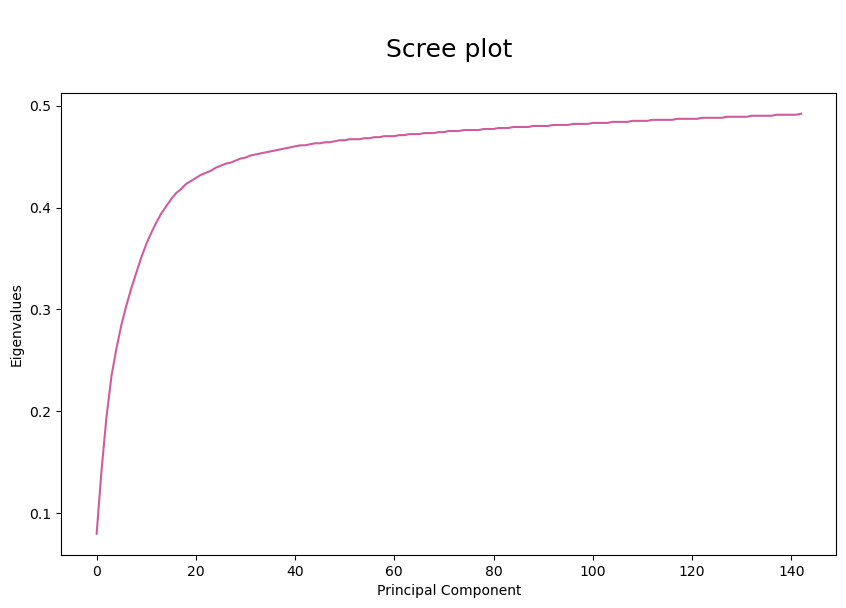

In [64]:
plt.figure(figsize=(10,6))
plt.title('\nScree plot\n', fontsize=18)
plt.plot(np.arange(143), explained_variance, color='#D05C9C')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalues')
plt.show()

In [65]:
pca_60 = PCA(n_components=60, svd_solver='full')
df_scaled_60 = pca.fit(df_scaled).transform(df_scaled)

#### k-means

In [66]:
K = range(10, 80)
models = [KMeans(n_clusters = k, random_state=8, n_init=10,max_iter = 10000).fit(df_scaled_60) for k in K]
dist = [model.inertia_ for model in models]

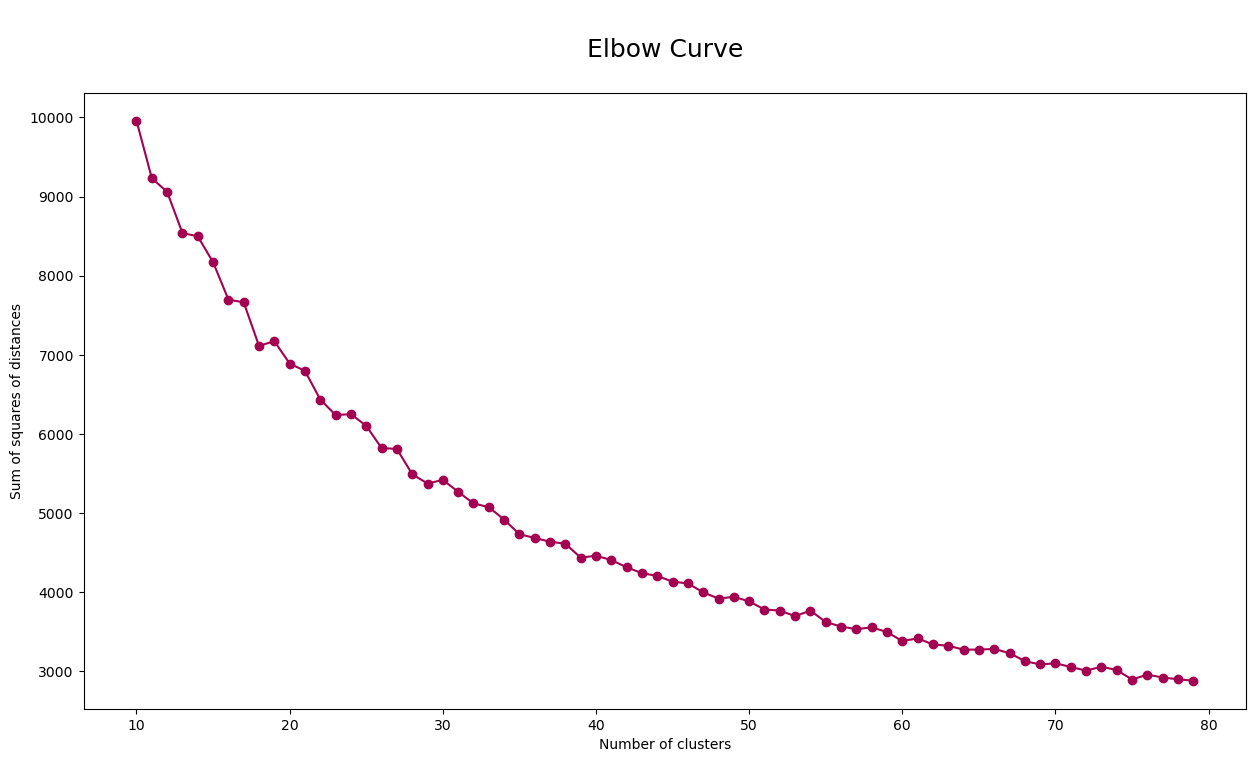

In [67]:
plt.figure(figsize=(15,8))
plt.plot(K, dist, marker='o', color='#a30052')
plt.xlabel('Number of clusters')
plt.ylabel('
           ')
plt.title('\nElbow Curve\n', fontsize=18)
plt.show()

In [68]:
# about 35 clusters before curve starts looking flat. Checking from range 20-40

In [69]:
range_n_clusters = range(20, 41, 5)
for n_clusters in range_n_clusters:
    
    models1 = KMeans(n_clusters=n_clusters, random_state=8, n_init=10,max_iter=10000)
    model_labels = models1.fit_predict(df_scaled_60)
    
    silhouette_avg = silhouette_score(df_scaled_60, model_labels)
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

For n_clusters = 20 The average silhouette_score is : 0.41240572440948464
For n_clusters = 25 The average silhouette_score is : 0.4409733646565956
For n_clusters = 30 The average silhouette_score is : 0.4917506227311401
For n_clusters = 35 The average silhouette_score is : 0.5344330402228402
For n_clusters = 40 The average silhouette_score is : 0.5562668887165602


In [70]:
models_150 = KMeans(n_clusters=900, random_state=8, n_init=10,max_iter = 10000)
model_labels_150 = models_150.fit_predict(df_scaled_60)
silhouette_avg_150 = silhouette_score(df_scaled_60, model_labels_150)
print("For n_clusters =", 150, "The average silhouette_score is :", silhouette_avg_150)

For n_clusters = 150 The average silhouette_score is : 0.9427494242256164


In [90]:
df[f'{i}_clusters'] = models_150.labels_

In [ ]:
# df.to_csv('df.csv', index=False)